# TME2 - Inférence Collective

In [54]:
%matplotlib inline
from collections import OrderedDict
import numpy as np
from sklearn.svm import LinearSVC
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy

## Chargement des données

In [55]:
def loadData(dir="WebKB/", university="cornell"):
    content = OrderedDict()
    labels = set()
    for l in open(dir+"content/"+university+".content", "r"):
        attributes = l.split('\t')
        label = attributes[-1][:-1]  # Enlever \n
        labels.add(label)
        content[attributes[0]] = {}
        content[attributes[0]]['attributs'] = attributes[1:-1]
        content[attributes[0]]['label'] = label
        content[attributes[0]]['successeurs'] = set()
        content[attributes[0]]['predecesseurs'] = set()
        content[attributes[0]]['voisins'] = set()
        content[attributes[0]]['inconnu'] = False
    for l in open(dir+"cites/"+university+".cites", "r"):
        sites = l[:-1].split(' ')
        content[sites[0]]['successeurs'].add(sites[1])
        content[sites[1]]['predecesseurs'].add(sites[0])
        content[sites[0]]['voisins'].add(sites[1])
        content[sites[1]]['voisins'].add(sites[0])
    return content, list(labels)

In [56]:
graph, classes = loadData()

In [57]:
for i,label in enumerate(classes):
    print(i,label)

0 student
1 faculty
2 course
3 project
4 staff


In [58]:
# Selection aleatoire des labels inconnus
tauxInconnu = .10
nbrInconnu = int(len(graph.keys()) * tauxInconnu)
indicesAleatoires = np.random.permutation(len(graph.keys()))
indiceInconnuOrdonee = np.sort(indicesAleatoires[:nbrInconnu])
inconnus = np.array(list(graph.keys()))[indiceInconnuOrdonee]
print (inconnus)

['http://www.cs.cornell.edu/info/courses/current/cs401/home.html'
 'http://www.cs.cornell.edu/info/courses/current/cs631/welcome.html'
 'http://www.cs.cornell.edu/info/courses/fall-95/cs501/cs401-501.html'
 'http://www.cs.cornell.edu/info/courses/spring-96/cs211/cs211.html'
 'http://www.cs.cornell.edu/info/courses/spring-96/cs512/home.html'
 'http://www.cs.cornell.edu/info/department/annual95/faculty/birman.html'
 'http://www.cs.cornell.edu/info/people/chichao/chichao.html'
 'http://www.cs.cornell.edu/info/people/ckliau/ckliau.html'
 'http://www.cs.cornell.edu/info/people/crary/home.html'
 'http://www.cs.cornell.edu/info/people/eva/eva.html'
 'http://www.cs.cornell.edu/info/people/gbd/gbd.html'
 'http://www.cs.cornell.edu/info/people/kguo/home.html'
 'http://www.cs.cornell.edu/info/people/millett/home.html'
 'http://www.cs.cornell.edu/info/people/ronitt/homepage.html'
 'http://www.cs.cornell.edu/info/people/wwlee/wwlee.html'
 'http://www.cs.cornell.edu/info/people/yanhong/cachet.html'


## Classifieur local

In [59]:
#Extraction de features
def pretraitement(graph, classes, inconnus):
    nbrNodes = len(graph.keys())
    nbrAtt = len(graph[list(graph.keys())[0]]['attributs'])
    nbrClass = len(classes)
    nbrInconnus = len(inconnus)
    data = {}
    data['inconnu'] = np.zeros((nbrInconnus, nbrAtt + nbrClass))
    data['connu'] = np.zeros((nbrNodes - nbrInconnus, nbrAtt + nbrClass))
    labels = {}
    labels['inconnu'] = np.zeros(nbrInconnus)
    labels['connu'] = np.zeros(nbrNodes - nbrInconnus)
    i = {}
    i['inconnu'] = 0
    i['connu'] = 0
    for node in graph:
        if (node in inconnus):
            k = 'inconnu'
        else:
            k = 'connu'
        data[k][i[k],:nbrAtt] = graph[node]['attributs']
        labels[k][i[k]] = classes.index(graph[node]['label'])
        for s in graph[node]['successeurs']:
            if (s not in inconnus):
                indiceLabel = classes.index(graph[s]['label'])
                data[k][i[k],nbrAtt + indiceLabel] += 1
        i[k] += 1
    return data, labels

In [60]:
data, labels = pretraitement(graph, classes, inconnus)
#print (data["inconnu"])
#print (labels["connu"])

classifierLocal = LinearSVC()
classifierLocal.fit(data["connu"], labels["connu"])
prediction = classifierLocal.predict(data["inconnu"])
print ("Le score du classifieur local:", (prediction == labels["inconnu"]).mean())

Le score du classifieur local: 0.842105263158


## ICA

In [61]:
class ICA(object):
    def __init__(self, clfLocal, nbrIter=1000):
        self.clfLocal = clfLocal
        self.nbrIter = nbrIter
    
    def predict(self, graph, classes, inconnus):
        data, labels = pretraitement(graph, classes, inconnus)
        self.clfLocal.fit(data["connu"], labels["connu"])
        a = self.clfLocal.predict(data["inconnu"])
        for i,u in enumerate(inconnus):  # initialisation avec bootstrapping
            graph[u]['label'] = classes[int(a[i])]  
        y = np.zeros(a.shape)
        for k in range(self.nbrIter):
            inconnuReordonne = np.random.permutation(len(inconnus)) # Reordonner les noeuds aleatoirement
            for i in inconnuReordonne:
                node = inconnus[i]
                nbrAtt = len(graph[node]['attributs'])
                nbrClass = len(classes)
                feature = np.zeros(nbrAtt + nbrClass)
                feature[:nbrAtt] = graph[node]['attributs']
                for s in graph[node]['successeurs']:
                    indiceLabel = classes.index(graph[s]['label'])
                    feature[nbrAtt + indiceLabel] += 1
                y[i] = self.clfLocal.predict(np.array([feature])) # Prediction de ce noeud
                graph[node]['label'] = classes[int(y[i])]
            if ((a == y).mean() == 1):
                break
            a = deepcopy(y)  # Mise a jour de vecteur a
        
        return a, labels
        

In [63]:
graphe = deepcopy(graph)
ica = ICA(LinearSVC())
y, label= ica.predict(graphe, classes, inconnus)
print ("Le score de l'ICA : ", (y == label['inconnu']).mean())

Le score de l'ICA :  0.842105263158


## Propagation de labels
### [Denoyer & Gallinari, 2010]:

In [64]:
class propagationLabel():
    def __init__(self, beta=1e-2, lambd=1e-2, eps=1e-4, nbrIter=100):
        self.beta  = beta
        self.lambd = lambd
        self.eps = eps
        self.nbrIter = nbrIter
    
    def predict(self, graph, classes, inconnus):
        connu = list(set(graph.keys()).difference(set(inconnus)))
        nbrAtt = len(graph[list(graph.keys())[0]]['attributs'])
        nbrClass = len(classes)
        self.loss = []
        self.theta = np.random.random((nbrClass, nbrAtt))

        for i in range(self.nbrIter):
            lossHL = np.zeros(nbrClass)
            lossConnect = np.zeros(nbrClass)
            lossRegu = np.zeros(nbrClass)
            connuReordonne = np.random.permutation(connu)
            for node in connuReordonne:
                yneg = np.ones((nbrClass))
                 
                xi = np.array(graph[node]['attributs'], float)
                gradHL = yneg.reshape(5,1) * xi.reshape((1,len(xi))) # gradient de Hinge Loss  (- y * x)
                produitHL = yneg * (np.dot(xi,self.theta.T))
                gradHL[produitHL <= 1] = 0
                produitHL = 1 + produitHL   # 1 - y * X * theta
                produitHL[produitHL < 0] = 0  # max(0, 1 - y * X * theta)
                lossHL = lossHL + produitHL        
                
                gradConnect = np.zeros(self.theta.shape)
                for j in (graph[node]['successeurs']):
                    xj = np.array(graph[j]['attributs'], float)
                    diff = xi - xj
                    produitConnect = np.dot(diff, self.theta.T)
                    gradConnect = gradConnect + 2 * self.beta * produitConnect.reshape(nbrClass,1) * diff.reshape((1,len(diff))).repeat(nbrClass, axis=0)
                    # gradient des scores entre deux noeuds connectes 
                    lossConnect = lossConnect + self.beta * (produitConnect**2)
                    
                gradRegu = 2 * self.lambd / len(connu) * self.theta  # gradient de la regulatisation
                lossRegu = lossRegu + self.lambd / len(connu) * (self.theta**2).sum(1)
                
                self.theta = self.theta - self.eps * (gradHL + gradConnect + gradRegu)
            
            self.loss.append(np.array([lossHL+lossConnect+lossRegu]).mean())
        
        target = np.zeros(len(inconnus))
        for i,node in enumerate(inconnus):
            target[i] = np.dot(np.array(graph[node]['attributs'], float), self.theta.T).argmax()
        return target

In [65]:
graphe2 = deepcopy(graph)
pl = propagationLabel(beta=0.001, lambd=0.001, eps=0.001, nbrIter=100)
predPro = pl.predict(graphe2, classes, inconnus) 
print ("Le score de propagation de labels:", (predPro == label['inconnu']).mean())

Le score de propagation de labels: 0.631578947368


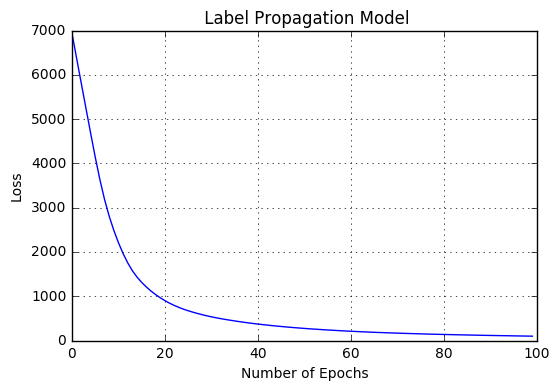

In [66]:
plt.plot(pl.loss)
plt.title(' Label Propagation Model')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()